# **Step 1**

Not Hate    23353
Hate         1430
Name: count, dtype: int64




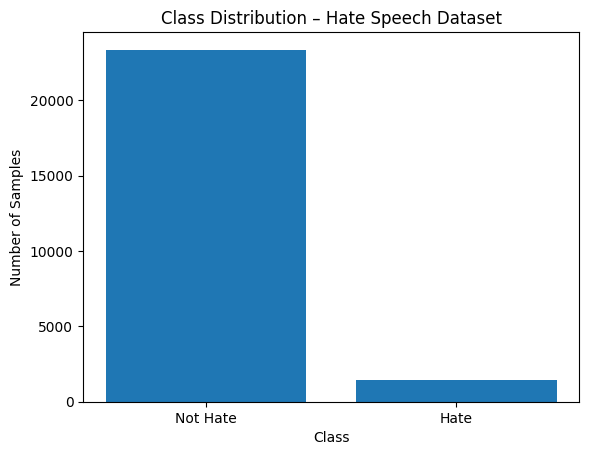

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/labeled_data.csv")

# تحويل إلى Binary:
# 0 = Hate Speech, 1 = Offensive, 2 = Neither
df["binary_label"] = df["class"].apply(lambda x: 1 if x == 0 else 0)

counts = df["binary_label"].value_counts()
counts.index = ["Not Hate", "Hate"]

print(counts)
print("\n")
plt.bar(counts.index, counts.values)
plt.title("Class Distribution – Hate Speech Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()


# **Step 2**

**Preparing Hate category data only**

In [77]:
# Preparing hate speech category data only
# Filter hate speech data only (minority class)

hate_df = df[df['class'] == 0]

# View sample
hate_df.head()



,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,binary_label
85,85,3,2,1,0,0,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1...",1
89,90,3,3,0,0,0,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ...",1
110,111,3,3,0,0,0,"""@DevilGrimz: @VigxRArts you're fucking gay, b...",1
184,186,3,3,0,0,0,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL...",1
202,204,3,2,1,0,0,"""@NoChillPaz: ""At least I'm not a nigger"" http...",1


In [78]:
print("Number of hate speech samples:", len(hate_df))


Number of hate speech samples: 1430


In [79]:
hate_texts = hate_df['tweet'].astype(str)

hate_texts.head()


,tweet
85,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1..."
89,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ..."
110,"""@DevilGrimz: @VigxRArts you're fucking gay, b..."
184,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL..."
202,"""@NoChillPaz: ""At least I'm not a nigger"" http..."


In [80]:
# represent texts as vectors so that we can train the GAN on them
from sklearn.feature_extraction.text import TfidfVectorizer

# Converting Hate Speech Text to Vectors Using TF-IDF
vectorizer = TfidfVectorizer(max_features=100)  # نموذج بسيط كبداية
hate_vectors = vectorizer.fit_transform(hate_df['tweet']).toarray()

# The format of the resulting data
print(hate_vectors.shape)


(1430, 100)


In [99]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

latent_dim = 50
input_dim = hate_vectors.shape[1]  # عدد خصائص TF-IDF

# Generator
def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(input_dim, activation='sigmoid')
    ])
    return model

# Discriminator
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # real vs fake
    ])
    return model

# Build models
generator = build_generator()
discriminator = build_discriminator()

# Compile discriminator
discriminator.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# GAN (Generator + Discriminator)
discriminator.trainable = False

gan_input = layers.Input(shape=(latent_dim,))
generated_data = generator(gan_input)
gan_output = discriminator(generated_data)

gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer='adam', loss='binary_crossentropy')


In [100]:
generator.summary()
discriminator.summary()
gan.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 100)            │         6,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,764 (38.14 KB)

 Trainable params: 9,764 (38.14 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,529 (25.50 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,529 (25.50 KB)

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 100)            │         9,764 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 1)              │         6,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,293 (63.64 KB)

 Trainable params: 9,764 (38.14 KB)

 Non-trainable params: 6,529 (25.50 KB)

In [101]:
epochs = 1000
batch_size = 32

real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

for epoch in range(epochs):

    # Train Discriminator
    idx = np.random.randint(0, hate_vectors.shape[0], batch_size)
    real_samples = hate_vectors[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_samples = generator.predict(noise, verbose=0)

    d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, real_labels)

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | D loss real: {d_loss_real[0]:.4f} | D loss fake: {d_loss_fake[0]:.4f} | G loss: {g_loss:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0 | D loss real: 0.6386 | D loss fake: 0.7756 | G loss: 0.5015
Epoch 100 | D loss real: 1.5199 | D loss fake: 1.5290 | G loss: 0.1347
Epoch 200 | D loss real: 1.8615 | D loss fake: 1.8669 | G loss: 0.0798
Epoch 300 | D loss real: 2.0545 | D loss fake: 2.0584 | G loss: 0.0583
Epoch 400 | D loss real: 2.1817 | D loss fake: 2.1847 | G loss: 0.0466
Epoch 500 | D loss real: 2.2738 | D loss fake: 2.2762 | G loss: 0.0392
Epoch 600 | D loss real: 2.3427 | D loss fake: 2.3447 | G loss: 0.0342
Epoch 700 | D loss real: 2.3967 | D loss fake: 2.3984 | G loss: 0.0305
Epoch 800 | D loss real: 2.4404 | D loss fake: 2.4419 | G loss: 0.0277
Epoch 900 | D loss real: 2.4762 | D loss fake: 2.4776 | G loss: 0.0254


In [84]:
# CGAN
# Generator

from tensorflow.keras import layers, models

def build_cgan_generator(latent_dim, output_dim, num_classes):
    noise_input = layers.Input(shape=(latent_dim,))
    label_input = layers.Input(shape=(1,), dtype='int32')

    label_embedding = layers.Embedding(num_classes, latent_dim)(label_input)
    label_embedding = layers.Flatten()(label_embedding)

    conditioned_input = layers.Multiply()([noise_input, label_embedding])

    x = layers.Dense(128, activation='relu')(conditioned_input)
    output = layers.Dense(output_dim, activation='sigmoid')(x)

    return models.Model([noise_input, label_input], output)



In [85]:
# Discriminator
def build_cgan_discriminator(input_dim, num_classes):
    data_input = layers.Input(shape=(input_dim,))
    label_input = layers.Input(shape=(1,), dtype='int32')

    label_embedding = layers.Embedding(num_classes, input_dim)(label_input)
    label_embedding = layers.Flatten()(label_embedding)

    conditioned_input = layers.Multiply()([data_input, label_embedding])

    x = layers.Dense(128, activation='relu')(conditioned_input)
    x = layers.Dense(1, activation='sigmoid')(x)

    return models.Model([data_input, label_input], x)


In [86]:
# Generator and discriminator setup
latent_dim = 50
input_dim = hate_vectors.shape[1]
num_classes = 2

cgan_generator = build_cgan_generator(latent_dim, input_dim, num_classes)
cgan_discriminator = build_cgan_discriminator(input_dim, num_classes)

cgan_discriminator.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

cgan_discriminator.trainable = False

noise = layers.Input(shape=(latent_dim,))
label = layers.Input(shape=(1,), dtype='int32')

generated_data = cgan_generator([noise, label])
validity = cgan_discriminator([generated_data, label])

cgan = models.Model([noise, label], validity)
cgan.compile(optimizer='adam', loss='binary_crossentropy')


In [87]:
# CGAN Training (Hate Speech)

epochs = 1000
batch_size = 32

# labels for real/fake
real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

# minority data tensor
hate_tensor = tf.convert_to_tensor(hate_vectors, dtype=tf.float32)

for epoch in range(epochs):

    # Train Discriminator

    idx = np.random.randint(0, hate_vectors.shape[0], batch_size)
    real_samples = tf.gather(hate_tensor, idx)

    # label = 1 → Hate
    real_class_labels = np.ones((batch_size, 1), dtype=np.int32)

    noise = tf.random.normal((batch_size, latent_dim))
    fake_class_labels = np.ones((batch_size, 1), dtype=np.int32)

    generated_samples = cgan_generator.predict(
        [noise, fake_class_labels], verbose=0
    )

    d_loss_real = cgan_discriminator.train_on_batch(
        [real_samples, real_class_labels], real_labels
    )

    d_loss_fake = cgan_discriminator.train_on_batch(
        [generated_samples, fake_class_labels], fake_labels
    )

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator

    noise = tf.random.normal((batch_size, latent_dim))
    misleading_labels = np.ones((batch_size, 1))  # want discriminator to think real

    g_loss = cgan.train_on_batch(
        [noise, fake_class_labels], misleading_labels
    )

    if epoch % 100 == 0:
        print(
            f"Epoch {epoch} | "
            f"D_loss: {d_loss[0]:.4f} | "
            f"D_acc: {d_loss[1]*100:.2f}% | "
            f"G_loss: {g_loss:.4f}"
        )


Epoch 0 | D_loss: 0.6927 | D_acc: 27.34% | G_loss: 0.6996
Epoch 100 | D_loss: 0.6977 | D_acc: 23.60% | G_loss: 0.6856
Epoch 200 | D_loss: 0.7043 | D_acc: 13.54% | G_loss: 0.6729
Epoch 300 | D_loss: 0.7068 | D_acc: 10.20% | G_loss: 0.6681
Epoch 400 | D_loss: 0.7081 | D_acc: 8.51% | G_loss: 0.6657
Epoch 500 | D_loss: 0.7089 | D_acc: 7.49% | G_loss: 0.6642
Epoch 600 | D_loss: 0.7094 | D_acc: 6.82% | G_loss: 0.6632
Epoch 700 | D_loss: 0.7098 | D_acc: 6.35% | G_loss: 0.6624
Epoch 800 | D_loss: 0.7101 | D_acc: 5.99% | G_loss: 0.6619
Epoch 900 | D_loss: 0.7103 | D_acc: 5.72% | G_loss: 0.6615


In [89]:
#WGAN
#Generator
def build_wgan_generator():
    model = models.Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(input_dim, activation='sigmoid')
    ])
    return model



In [90]:
#Critic
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

latent_dim = 50
input_dim = hate_vectors.shape[1]

def build_wgan_critic():
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)  # no sigmoid in WGAN
    ])
    return model


In [91]:
wgan_generator = build_wgan_generator()
wgan_critic = build_wgan_critic()

critic_optimizer = tf.keras.optimizers.RMSprop(learning_rate=5e-5)
generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=5e-5)


In [92]:
epochs = 500          # أقل من GAN العادي
batch_size = 32
clip_value = 0.01     # Weight Clipping

hate_tensor = tf.convert_to_tensor(hate_vectors, dtype=tf.float32)

for epoch in range(epochs):

    # Train Critic
    idx = np.random.randint(0, hate_vectors.shape[0], batch_size)
    real_samples = tf.gather(hate_tensor, idx)

    noise = tf.random.normal((batch_size, latent_dim))
    fake_samples = wgan_generator(noise)

    with tf.GradientTape() as tape:
        loss_critic = tf.reduce_mean(wgan_critic(fake_samples)) - \
                      tf.reduce_mean(wgan_critic(real_samples))

    grads = tape.gradient(loss_critic, wgan_critic.trainable_variables)
    critic_optimizer.apply_gradients(zip(grads, wgan_critic.trainable_variables))

    # Weight clipping
    for var in wgan_critic.trainable_variables:
        var.assign(tf.clip_by_value(var, -clip_value, clip_value))

    # Train Generator
    noise = tf.random.normal((batch_size, latent_dim))
    with tf.GradientTape() as tape:
        fake_samples = wgan_generator(noise)
        loss_generator = -tf.reduce_mean(wgan_critic(fake_samples))

    grads = tape.gradient(loss_generator, wgan_generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(grads, wgan_generator.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Critic loss: {loss_critic:.4f} | Generator loss: {loss_generator:.4f}")


Epoch 0 | Critic loss: 1.4013 | Generator loss: -0.0068
Epoch 100 | Critic loss: -0.0247 | Generator loss: 0.0252
Epoch 200 | Critic loss: -0.0460 | Generator loss: 0.0461
Epoch 300 | Critic loss: -0.0666 | Generator loss: 0.0659
Epoch 400 | Critic loss: -0.0831 | Generator loss: 0.0829


# **Step 3**

**Original dataset (TF-IDF)**

In [108]:
# Original dataset
X_original_tfidf = vectorizer.fit_transform(df['tweet'].astype(str)).toarray()
y_original = df['class'].apply(lambda x: 1 if x == 0 else 0).values

print("Original distribution:")
print("Not Hate:", sum(y_original == 0))
print("Hate:", sum(y_original == 1))


Original distribution:
Not Hate: 23353
Hate: 1430


**Balanced with Vanilla GAN**

In [109]:
# Number of samples needed to balance
num_to_generate = sum(y_original == 0) - sum(y_original == 1)

noise = tf.random.normal([num_to_generate, latent_dim])

generated_samples_vanilla = generator(noise).numpy()


In [110]:
#Merging samples with original data
y_synth_vanilla = np.ones(generated_samples_vanilla.shape[0])

X_bal_vanilla = np.vstack([X_original_tfidf, generated_samples_vanilla])
y_bal_vanilla = np.hstack([y_original, y_synth_vanilla])

print("\nBalanced with Vanilla GAN:")
print("Not Hate:", sum(y_bal_vanilla == 0))
print("Hate:", sum(y_bal_vanilla == 1))



Balanced with Vanilla GAN:
Not Hate: 23353
Hate: 23353


**Balanced with CGAN**

In [111]:
#Generating Hate samples using CGAN
noise = tf.random.normal([num_to_generate, latent_dim])
labels = np.ones((num_to_generate, 1), dtype=np.int32)

generated_samples_cgan = cgan_generator.predict(
    [noise, labels],
    verbose=0
)


In [112]:
#Merging samples with original data
y_synth_cgan = np.ones(generated_samples_cgan.shape[0])

X_bal_cgan = np.vstack([X_original_tfidf, generated_samples_cgan])
y_bal_cgan = np.hstack([y_original, y_synth_cgan])

print("\nBalanced with CGAN:")
print("Not Hate:", sum(y_bal_cgan == 0))
print("Hate:", sum(y_bal_cgan == 1))



Balanced with CGAN:
Not Hate: 23353
Hate: 23353


# **Step 4**

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score
)

def evaluate_classifier(X, y, name=""):

    # Split the data (stratified to preserve class distribution)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Train classifier
    clf = MLPClassifier(
        hidden_layer_sizes=(64,),
        max_iter=100,
        random_state=42
    )
    clf.fit(X_train, y_train)

    # Predictions
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)

    # Print results
    print(f"\n{name}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"AUC-ROC:   {auc:.4f}")
    print("Confusion Matrix:")
    print(cm)

    #return everything
    return {
        "Dataset": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "AUC-ROC": auc,
        "Confusion Matrix": cm
    }


In [130]:
results_all = []

results_all.append(
    evaluate_classifier(X_original_tfidf, y_original, "Original Imbalanced")
)

results_all.append(
    evaluate_classifier(X_bal_vanilla, y_bal_vanilla, "Vanilla GAN Balanced")
)

results_all.append(
    evaluate_classifier(X_bal_cgan, y_bal_cgan, "CGAN Balanced")
)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



Original Imbalanced
Accuracy:  0.9352
Precision: 0.2667
Recall:    0.0699
F1-Score:  0.1108
AUC-ROC:   0.7334
Confusion Matrix:
[[4616   55]
 [ 266   20]]


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



Vanilla GAN Balanced
Accuracy:  0.9641
Precision: 0.9824
Recall:    0.9452
F1-Score:  0.9634
AUC-ROC:   0.9834
Confusion Matrix:
[[4592   79]
 [ 256 4415]]

CGAN Balanced
Accuracy:  0.9635
Precision: 0.9811
Recall:    0.9452
F1-Score:  0.9628
AUC-ROC:   0.9837
Confusion Matrix:
[[4586   85]
 [ 256 4415]]


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [132]:
import pandas as pd

results_df = pd.DataFrame(results_all)
results_df


,Dataset,Accuracy,Precision,Recall,F1-Score,AUC-ROC,Confusion Matrix
0,Original Imbalanced,0.935243,0.266667,0.069930,0.110803,0.733358,"[[4616, 55], [266, 20]]"
1,Vanilla GAN Balanced,0.964140,0.982421,0.945194,0.963448,0.983392,"[[4592, 79], [256, 4415]]"
2,CGAN Balanced,0.963498,0.981111,0.945194,0.962818,0.983703,"[[4586, 85], [256, 4415]]"


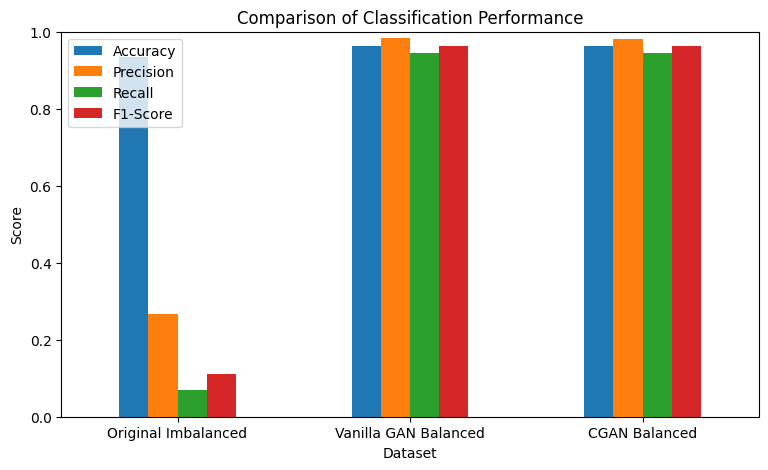

In [133]:
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

results_df.set_index("Dataset")[metrics].plot(
    kind="bar",
    figsize=(9,5)
)

plt.title("Comparison of Classification Performance")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.show()


**Confusion Matrix**

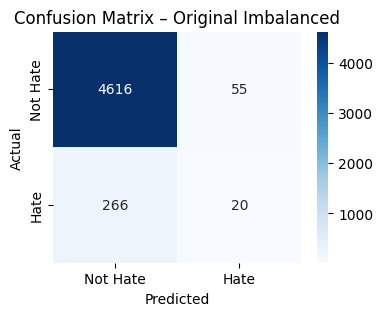

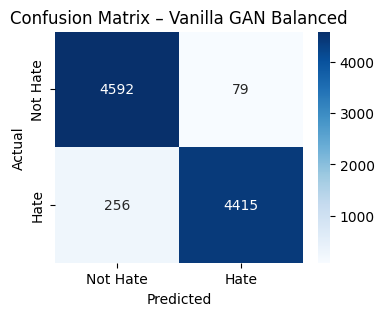

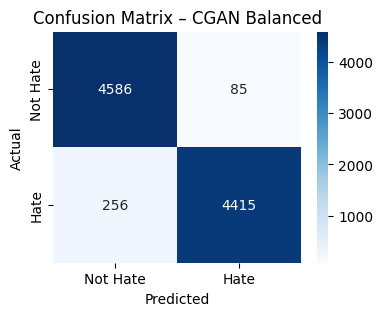

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

for res in results_all:
    cm = res["Confusion Matrix"]

    plt.figure(figsize=(4,3))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Not Hate", "Hate"],
        yticklabels=["Not Hate", "Hate"]
    )
    plt.title(f"Confusion Matrix – {res['Dataset']}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
